In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
#data_folder = Path("C:/Users/merri/OneDrive/Nan's NW/Capstone")

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


# import Natural Language Tookit
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import re

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as k
from tensorflow.keras.metrics import AUC

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer

from packaging import version
from tensorflow.python.client import device_lib

# for BERT tokenization
# from transformers import BertTokenizer, TFAutoModel

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# for Glove tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# SMOTE oversampling
from imblearn.over_sampling import SMOTE


In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

device_lib.list_local_devices()

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15396001297995995495
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22385000448
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1249866388123353087
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

In [3]:



# Download the stopwords and punkt tokenizer models
nltk.download('stopwords')
nltk.download('punkt')

# Function to determine the type of product number
def determine_number_type(s):
    if '.' in s:
        return 'float'
    elif '-' in s:
        return 'hyphenated'
    elif s.isdigit():  # checks if the string contains only numbers
        return 'numeric'
    else:
        return 'alphanumeric'

stop_words = set(stopwords.words('english'))

# Create a function to tokenize the Product_Description column based on the specified requirements:
# Convert underscores _ to spaces.
# Tokenize using spaces, commas, and other special characters.
# Filter out stopwords.
def combined_tokenizer(description):
    # Convert underscores to spaces
    description = description.replace("_", " ")

    # Tokenize based on spaces, commas, and other delimiters
    tokens = re.split(r'[ ,;()\n]+', description)

    # Tokenize further using alphanumeric boundaries
    refined_tokens = []
    for token in tokens:
        refined_tokens.extend(re.findall(r'\d+|\D+', token))
    
    # Filter out stopwords
    refined_tokens = [word for word in refined_tokens if word.lower() not in stop_words and len(word) > 1]

    return refined_tokens

# Assuming digits in Product_Description are refering to size/dimension of a product
# and may not play a significant role in classification.
# Remove digits and mean from a list of tokens and .

def remove_digits(tokens_list):
    return [token for token in tokens_list if not token.isdigit()]

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Import dataset
df=pd.read_csv('../Dataset/Commodity_Item_Master.csv')

# Delete the last two columns
df1 = df.drop(df.columns[-1:], axis = 1)

# Rename columns
columns = df1.columns.to_list() # NOTE: Commodity_Item_Master.csv has 'ï»¿Product #' column with non-alphanumeric characters; will rename to 'Product ID'
rename_dict = {
    columns[0]:'Product ID',
    columns[2]:'UNSPSC CODES',
    columns[3]:'UNSPSC Code Description'
}
df2 = df1.rename(columns = rename_dict)


# Delete rows with missing values
df3 = df2.dropna()

# Convert'UNSPSC CODES' from float to int
df3['UNSPSC CODES']=df3['UNSPSC CODES'].astype(int)

# Looks like row 294 has false UNSPSC Codes and UNSPSC Code Description, delete row 294
df4 = df3.drop(294)

# keep one row from the set of duplicated rows
df5 = df4.drop_duplicates(subset='Product ID', keep='first')

df5['ProductID_Type'] = df5['Product ID'].apply(determine_number_type)

### DESCRIPTIONS and Product ID
# Convert to lowercase for consistency
df5['DESCRIPTIONS']=df5['DESCRIPTIONS'].str.lower()
df5['Product ID']=df5['Product ID'].str.lower()

# Remove periods
df5['DESCRIPTIONS'] = df5['DESCRIPTIONS'].str.replace('.', '')
# ***** NOTE - PLEASE REVIEW: Do we need to remove periods to Product ID as well? *****
# df5['Product ID'] = df5['Product ID'].str.replace('.', '')

# Apply the function to the DESCRIPTIONS column
df5['TOKENS'] = df5['DESCRIPTIONS'].apply(combined_tokenizer)

# combine 'Product ID' and 'DESCRIPTIONS' columns into one column
df5['Product_Description'] = df5[['Product ID', 'DESCRIPTIONS']].apply(lambda x: ','.join(x), axis=1)

# Delete the row with '_na' as DESCRIPTIONS
df6 = df5[df5['DESCRIPTIONS']!='_na']


# Apply the function to the TOKENS column
df6['TOKENS'] = df6['TOKENS'].apply(remove_digits)

### UNSPSC Code Description
#### UNSPSC CODES_Segment Level
# Check how many types of Segments, which is the first level, in the UNSPSC CODES
# Convert UNSPSC CODES to string and extract the first two digits
df6['Segment'] = df6['UNSPSC CODES'].astype(str).str[:2]
df6['Family'] = df6['UNSPSC CODES'].astype(str).str[:4]
df6['Class'] = df6['UNSPSC CODES'].astype(str).str[:6]
df6['Commodity'] = df6['UNSPSC CODES'].astype(str).str[:8]

# Delete the only one entry that uses 811115035.
df6 = df6[df6['UNSPSC CODES'] != '811115035']

# Remove the string 'mm' from a list of tokens
df6['TOKENS'] = df6['TOKENS'].apply(lambda tokens: [token for token in tokens if token != 'mm'])


In [5]:
df6

,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706
...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221


<Axes: ylabel='Commodity'>

19720

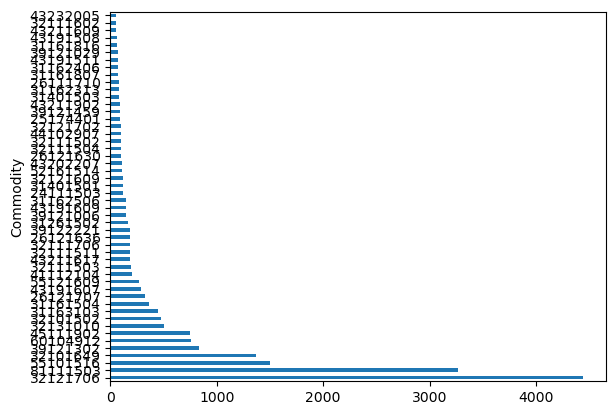

In [6]:
# get a dataframe of the top 50 Commodity CODES
y_top_50 = df6['Commodity'].value_counts().head(50)
df7 = df6[df6['Commodity'].isin(y_top_50.index.tolist())]
df7['Commodity'].value_counts().plot(kind='barh')

len(df7)

In [7]:
# Use label encoder to encode the Family CODES
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df7['Commodity'])

# Use one hot encoder to encode the Family CODES
one_hot_encoder = OneHotEncoder(sparse=False)
y_one_hot_encoded = one_hot_encoder.fit_transform(df7[['Commodity']])


In [8]:
# tokenize the descriptions
df7['tokens_w2v'] = df7['Product_Description'].apply(word_tokenize)

# train the word2vec model
model_w2v = Word2Vec(df7['tokens_w2v'], vector_size=100, window=5, min_count=1, workers=4)

# create a dictionary with words and their corresponding vectors
word_vectors = model_w2v.wv

# create a list of vectors for each description
vectors = []
for tokens in df7['tokens_w2v']:
    vector = np.zeros(100)
    for token in tokens:
        vector += word_vectors[token]
    vectors.append(vector)
    
# create a dataframe with the vectors
df_vectors = pd.DataFrame(vectors, columns=['w2v_'+str(i) for i in range(100)])


In [9]:
# split X and y_encoded into training test and validation sets
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(df_vectors, y_encoded, test_size=0.1, random_state=42)
X_train_enc, X_val_enc, y_train_enc, y_val_enc = train_test_split(X_train_enc, y_train_enc, test_size=0.1, random_state=42)

In [10]:
# convert the true labels from one-hot encoded format to class labels
y_test_labels_enc = label_encoder.inverse_transform(y_test_enc)


In [11]:
# # create the SMOTE object
smote = SMOTE()

# # fit and apply SMOTE to the one-hot-encoded training data
X_train_smote_enc, y_train_smote_enc = smote.fit_resample(X_train_enc, y_train_enc)

# # print the shape of the new training data
print('Shape of X_train_count_smote:', X_train_smote_enc.shape)
print('Shape of y_train_smote:', y_train_smote_enc.shape)


Shape of X_train_count_smote: (181950, 100)
Shape of y_train_smote: (181950,)


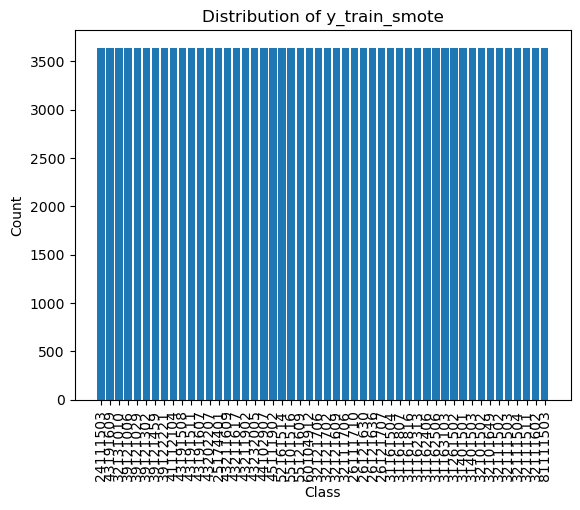

In [12]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # create a dataframe of the class counts
class_counts = pd.DataFrame(label_encoder.inverse_transform(y_train_smote_enc), columns=['class']).value_counts().reset_index(name='count')

# plot the class counts as a bar chart
plt.bar(class_counts['class'], class_counts['count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of y_train_smote')
plt.xticks(rotation=90)
plt.show();


In [13]:
# default model callback settings

def create_checkpoint(model_name):
    return ModelCheckpoint(
        filepath=model_name,
        mode='min',
        save_best_only=True,
        save_weights_only=False,
        monitor='val_loss',
        verbose=1
    )

early_stopping = EarlyStopping(patience=20, restore_best_weights=True,monitor='val_loss')

In [16]:
k.clear_session()
model_w2v = Sequential()
model_w2v.add(Dense(64, input_shape=(df_vectors.shape[1],), activation='relu'))
model_w2v.add(Dropout(0.5))
model_w2v.add(Dense(50, activation='softmax'))
model_w2v.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_w2v.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                3250      
                                                                 
Total params: 9,714
Trainable params: 9,714
Non-trainable params: 0
_________________________________________________________________


In [17]:
history_w2v = model_w2v.fit(X_train_enc, y_train_enc, validation_data=(X_val_enc, y_val_enc), epochs=200, batch_size=64,
        callbacks=[create_checkpoint('best_model_nn_w2v_prodmod_enc.h5'),early_stopping], verbose=1)


Epoch 1/200
249/250 [============================>.] - ETA: 0s - loss: 3.2835 - accuracy: 0.3290
Epoch 1: val_loss improved from inf to 2.39478, saving model to best_model_nn_w2v_prodmod_enc.h5
250/250 [==============================] - 1s 2ms/step - loss: 3.2817 - accuracy: 0.3292 - val_loss: 2.3948 - val_accuracy: 0.4406
Epoch 2/200
222/250 [=========================>....] - ETA: 0s - loss: 2.4915 - accuracy: 0.4191
Epoch 2: val_loss improved from 2.39478 to 2.22010, saving model to best_model_nn_w2v_prodmod_enc.h5
250/250 [==============================] - 0s 1ms/step - loss: 2.4813 - accuracy: 0.4197 - val_loss: 2.2201 - val_accuracy: 0.4648
Epoch 3/200
222/250 [=========================>....] - ETA: 0s - loss: 2.3292 - accuracy: 0.4398
Epoch 3: val_loss improved from 2.22010 to 2.12596, saving model to best_model_nn_w2v_prodmod_enc.h5
250/250 [==============================] - 0s 1ms/step - loss: 2.3337 - accuracy: 0.4398 - val_loss: 2.1260 - val_accuracy: 0.4851
Epoch 4/200
225/2

In [18]:
pred_nn = model_w2v.predict(X_test_enc)
pred_nn_decoded = label_encoder.inverse_transform(np.argmax(pred_nn, axis=1))
print_validation_report(y_test_labels_enc, pred_nn_decoded)


62/62 [==============================] - 0s 822us/step
Classification Report
              precision    recall  f1-score   support

    24111503       0.00      0.00      0.00        11
    25174401       0.00      0.00      0.00         6
    26111710       0.00      0.00      0.00         5
    26121630       0.00      0.00      0.00        10
    26121636       1.00      0.93      0.96        14
    26121707       0.31      0.54      0.39        28
    31161504       0.38      0.09      0.15        53
    31161807       0.00      0.00      0.00        12
    31161816       0.00      0.00      0.00         9
    31162313       0.00      0.00      0.00         6
    31162406       0.00      0.00      0.00        10
    31162506       0.00      0.00      0.00        14
    31163103       0.30      0.66      0.41        47
    31261502       0.00      0.00      0.00        14
    31401501       0.00      0.00      0.00        15
    31401503       0.00      0.00      0.00         8
    

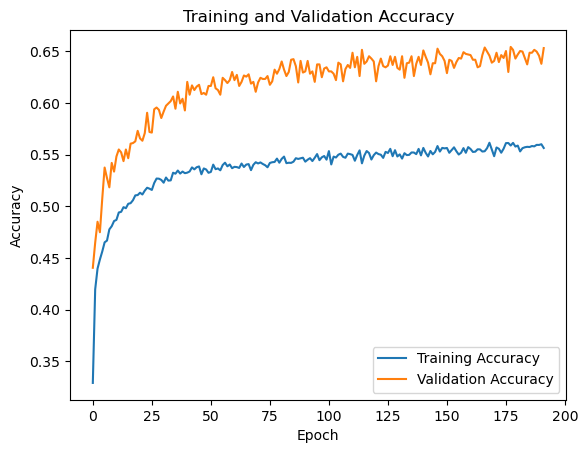

In [19]:
# plot the training and validation accuracy
plt.plot(history_w2v.history['accuracy'])
plt.plot(history_w2v.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

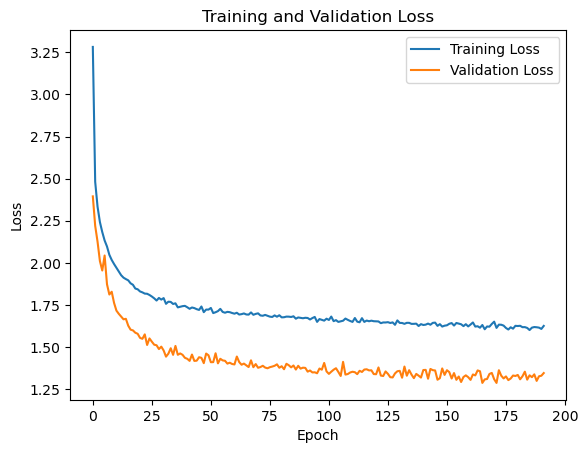

In [20]:
# plot the training and validation loss
plt.plot(history_w2v.history['loss'])
plt.plot(history_w2v.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();


In [26]:
# create a logistic regression object
logreg = LogisticRegression()

# fit the model on the training data
# logreg.fit(X_train_glove_enc.reshape(X_train_glove_enc.shape[0], -1), y_train_enc)
logreg.fit(X_train_smote_enc, y_train_smote_enc)


LogisticRegression()

In [27]:
# evaluate the model on the testing data
# accuracy = logreg.score(X_test_glove_enc.reshape(X_test_glove_enc.shape[0], -1), y_test_enc)
accuracy_lr = logreg.score(X_test_enc, y_test_enc)
print('Test accuracy:', accuracy_lr)

Test accuracy: 0.4264705882352941


In [28]:
pred_lr = logreg.predict(X_test_enc)
pred_lr_decoded = label_encoder.inverse_transform(pred_lr)
print_validation_report(y_test_labels_enc, pred_lr_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       0.53      0.82      0.64        11
    25174401       0.00      0.00      0.00         6
    26111710       0.11      0.40      0.17         5
    26121630       0.10      0.20      0.13        10
    26121636       0.68      0.93      0.79        14
    26121707       0.35      0.61      0.44        28
    31161504       0.71      0.45      0.55        53
    31161807       0.00      0.00      0.00        12
    31161816       0.11      0.22      0.14         9
    31162313       0.00      0.00      0.00         6
    31162406       0.12      0.50      0.20        10
    31162506       0.18      0.14      0.16        14
    31163103       0.67      0.13      0.21        47
    31261502       0.24      0.43      0.31        14
    31401501       0.07      0.13      0.09        15
    31401503       0.00      0.00      0.00         8
    32101502       0.74      0.74      0.74        50
    3

In [30]:
# create a MLPClassifier object
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=25, verbose=True, early_stopping=True)

# fit the model on the training data
mlp.fit(X_train_smote_enc, y_train_smote_enc)


Iteration 1, loss = 2.96121654
Validation score: 0.335312
Iteration 2, loss = 2.22506407
Validation score: 0.437263
Iteration 3, loss = 1.92955351
Validation score: 0.484419
Iteration 4, loss = 1.75316021
Validation score: 0.530640
Iteration 5, loss = 1.62327066
Validation score: 0.553559
Iteration 6, loss = 1.53178518
Validation score: 0.590932
Iteration 7, loss = 1.45558181
Validation score: 0.578236
Iteration 8, loss = 1.39567308
Validation score: 0.617148
Iteration 9, loss = 1.34236161
Validation score: 0.632481
Iteration 10, loss = 1.29757757
Validation score: 0.644738
Iteration 11, loss = 1.26033187
Validation score: 0.652047
Iteration 12, loss = 1.22349877
Validation score: 0.651168
Iteration 13, loss = 1.19438912
Validation score: 0.661226
Iteration 14, loss = 1.16583230
Validation score: 0.648145
Iteration 15, loss = 1.14505049
Validation score: 0.678648
Iteration 16, loss = 1.11972120
Validation score: 0.689255
Iteration 17, loss = 1.10161318
Validation score: 0.695905
Iterat

MLPClassifier(early_stopping=True, max_iter=25, verbose=True)

In [31]:
# evaluate the model on the testing data
accuracy_mlp = mlp.score(X_test_enc, y_test_enc)
print('Test accuracy:', accuracy_mlp)

Test accuracy: 0.7058823529411765


In [33]:
pred_mlp = mlp.predict(X_test_enc)
pred_mlp_decoded = label_encoder.inverse_transform(pred_mlp)
print_validation_report(y_test_labels_enc, pred_mlp_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       0.67      0.91      0.77        11
    25174401       0.56      0.83      0.67         6
    26111710       0.17      0.80      0.29         5
    26121630       0.17      0.50      0.25        10
    26121636       1.00      0.86      0.92        14
    26121707       0.86      0.68      0.76        28
    31161504       0.83      0.72      0.77        53
    31161807       0.14      0.42      0.21        12
    31161816       0.25      0.33      0.29         9
    31162313       0.11      0.33      0.16         6
    31162406       0.67      0.80      0.73        10
    31162506       0.31      0.57      0.40        14
    31163103       0.84      0.89      0.87        47
    31261502       0.57      0.57      0.57        14
    31401501       0.41      0.47      0.44        15
    31401503       0.18      0.38      0.24         8
    32101502       0.81      0.84      0.82        50
    3

In [36]:
# create the RandomForestClassifier object
rfc = RandomForestClassifier(verbose=1, random_state=42, n_jobs=-1)

# Train the RandomForestClassifier model
rfc.fit(X_train_smote_enc, y_train_smote_enc)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.5s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [37]:
pred_rfc = rfc.predict(X_test_enc)
pred_rfc_decoded = label_encoder.inverse_transform(pred_rfc)
print_validation_report(y_test_labels_enc, pred_rfc_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       0.56      0.82      0.67        11
    25174401       0.50      0.67      0.57         6
    26111710       0.30      0.60      0.40         5
    26121630       0.25      0.40      0.31        10
    26121636       0.92      0.86      0.89        14
    26121707       0.76      0.79      0.77        28
    31161504       0.76      0.74      0.75        53
    31161807       0.50      0.17      0.25        12
    31161816       0.33      0.44      0.38         9
    31162313       0.12      0.33      0.17         6
    31162406       0.50      0.70      0.58        10
    31162506       0.32      0.43      0.36        14
    31163103       0.80      0.91      0.85        47
    31261502       0.50      0.57      0.53        14
    31401501       0.54      0.47      0.50        15
    31401503       0.20      0.38      0.26         8
    32101502       0.81      0.88      0.85        50
    3

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished


In [14]:
# # create the MultinomialNB object
# nb = MultinomialNB()

# # fit the model to the training data
# nb.fit(X_train_smote_enc, y_train_smote_enc)


In [15]:
# pred_nb = nb.predict(X_test_enc)
# pred_nb_decoded = label_encoder.inverse_transform(pred_nb)
# print_validation_report(y_test_labels_enc, pred_nb_decoded)


In [16]:
# create the SVM object
svm = SVC(verbose=True, random_state=42)

# fit the model to the training data
svm.fit(X_train_smote_enc, y_train_smote_enc)


[LibSVM]

In [ ]:
pred_svm = svm.predict(X_test_enc)
pred_svm_decoded = label_encoder.inverse_transform(pred_svm)
print_validation_report(y_test_labels_enc, pred_svm_decoded)


Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      0.80      0.89         5
    26121630       1.00      0.56      0.71         9
    26121636       1.00      0.93      0.96        14
    26121707       0.87      0.96      0.92        28
    31161504       1.00      0.96      0.98        53
    31161807       1.00      0.67      0.80        12
    31161816       1.00      0.44      0.62         9
    31162313       0.67      0.40      0.50        10
    31162406       1.00      0.80      0.89        10
    31162506       0.76      0.93      0.84        14
    31163103       0.98      1.00      0.99        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       0.89      1.00      0.94         8
    32101502       0.92      0.98      0.95        50
    3

In [ ]:
# create the XGBClassifier object
# xgb = XGBClassifier(tree_method='gpu_hist')
xgb = XGBClassifier()

# fit the model to the training data
xgb.fit(X_train_smote_enc, y_train_smote_enc)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
pred_xgb = xgb.predict(X_test_enc)
pred_xgb_decoded = label_encoder.inverse_transform(pred_xgb)
print_validation_report(y_test_labels_enc, pred_xgb_decoded)


Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       0.80      0.80      0.80         5
    26121630       0.83      0.56      0.67         9
    26121636       1.00      0.93      0.96        14
    26121707       0.90      1.00      0.95        28
    31161504       1.00      0.98      0.99        53
    31161807       1.00      0.75      0.86        12
    31161816       1.00      0.67      0.80         9
    31162313       0.83      0.50      0.62        10
    31162406       0.89      0.80      0.84        10
    31162506       0.68      0.93      0.79        14
    31163103       0.98      0.96      0.97        47
    31261502       0.93      1.00      0.97        14
    31401501       0.93      0.93      0.93        15
    31401503       0.80      1.00      0.89         8
    32101502       0.94      1.00      0.97        50
    3